In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm

In [7]:
from sklearn.preprocessing import LabelEncoder

## Analyse des donnees

##### Les donnees de reference


In [8]:
reference = pd.read_csv("reference.csv")
reference_values = reference[reference.Meteo == "clear"].iloc[0]
reference_values

DateTime                      72
VehicleID                   veh1
X                              0
Y                              0
Longitude                      0
Latitude                       0
Speed                  14.336606
FuelConsumption    140413.685393
CO2Emission        440237.300605
TravelTime                  82.0
Meteo                      clear
ActionId                       0
ActionName                Aucune
ActionParam                    0
ActionDuration                 0
LaneMaxSpeed               16.66
Neighbors                      2
AllowedSpeed           15.632078
Name: 0, dtype: object

In [9]:
df = pd.read_csv("data_with_meteo.csv")
df.head(5)

,DateTime,VehicleID,X,Y,Longitude,Latitude,Speed,FuelConsumption,CO2Emission,TravelTime,Meteo,ActionId,ActionName,ActionParam,ActionDuration,LaneMaxSpeed,Neighbors,AllowedSpeed
0,34.0,veh1,651.697168,545.577109,1.469636,43.564773,6.830632,152788.347711,479024.537691,166.0,storm,3.0,stop,0.000000,8.0,8.330,2.0,7.816039
1,42.0,veh1,647.149998,598.183135,1.469567,43.565245,8.561617,134928.668392,423034.361881,125.0,snow,1.0,accelerate,6.573475,16.0,9.996,1.0,9.379247
2,10.0,veh1,0.000000,0.000000,0.000000,0.000000,0.000000,150983.229243,473368.562972,145.0,storm,0.0,Aucune,0.000000,0.0,0.000,0.0,0.000000
3,32.0,veh1,679.089003,558.295321,1.469972,43.564892,8.768699,141744.873601,444409.465593,91.0,rain,1.0,accelerate,4.445846,12.0,13.328,1.0,12.505662
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# suppression des lignes vides
data = df.dropna()
len(data)

909

In [11]:
len(data[(data.ActionId == 1) & (data.Meteo=="storm")])

58

<BarContainer object of 4 artists>

Text(0.5, 0, "Type d'action")

Text(0, 0.5, 'Fréquence')

Text(0.5, 1.0, 'Histogramme des occurrences des actions')

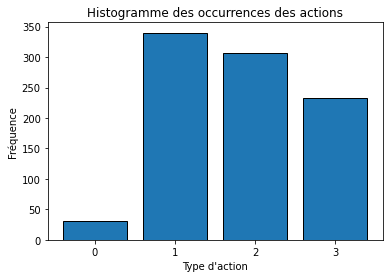

In [12]:
labels = [0,1,2,3]
# Comptage des occurrences de chaque label dans la colonne 'actionId'
counts = data['ActionId'].value_counts().reindex(labels, fill_value=0)

# Création de l'histogramme
plt.bar(counts.index, counts.values, tick_label=labels, edgecolor='black')

# Ajouter des labels et un titre
plt.xlabel("Type d'action")
plt.ylabel('Fréquence')
plt.title('Histogramme des occurrences des actions')

# Afficher l'histogramme
plt.show()

Text(0.5, 0, "Fuel's consumption")

Text(0, 0.5, 'CO2 Emission')

Text(0.5, 1.0, 'Relation FuelConsumption-CO2Emission')

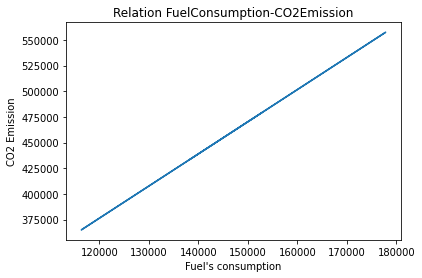

In [13]:
plt.plot(data['FuelConsumption'].tolist(), data['CO2Emission'].tolist())

plt.xlabel("Fuel's consumption")
plt.ylabel('CO2 Emission')
plt.title('Relation FuelConsumption-CO2Emission')

## Preparation des donnees X, y

Les donnees seront telles que si le trajet d'un scenario est superieur a celui du trajet de reference , le label du trajet sera ettiqueté a -1.
De meme si la consommation de carburant est superieur a celui du reference, le label sera -1

In [14]:
# Références pour les comparaisons
travel_reference = reference_values["TravelTime"]
fuel_reference = reference_values["FuelConsumption"]

# Ajouter la colonne y_travel
data['y_travel'] = data['TravelTime'].apply(lambda x: -1 if x > travel_reference else 1)

# Ajouter la colonne y_fuel
data['y_fuel'] = data['FuelConsumption'].apply(lambda x: -1 if x > fuel_reference else 1)


C:\Users\USER\AppData\Local\Temp/ipykernel_20856/584124041.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y_travel'] = data['TravelTime'].apply(lambda x: -1 if x > travel_reference else 1)
C:\Users\USER\AppData\Local\Temp/ipykernel_20856/584124041.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y_fuel'] = data['FuelConsumption'].apply(lambda x: -1 if x > fuel_reference else 1)


In [15]:
data.head(5)

,DateTime,VehicleID,X,Y,Longitude,Latitude,Speed,FuelConsumption,CO2Emission,TravelTime,Meteo,ActionId,ActionName,ActionParam,ActionDuration,LaneMaxSpeed,Neighbors,AllowedSpeed,y_travel,y_fuel
0,34.0,veh1,651.697168,545.577109,1.469636,43.564773,6.830632,152788.347711,479024.537691,166.0,storm,3.0,stop,0.000000,8.0,8.330,2.0,7.816039,-1,-1
1,42.0,veh1,647.149998,598.183135,1.469567,43.565245,8.561617,134928.668392,423034.361881,125.0,snow,1.0,accelerate,6.573475,16.0,9.996,1.0,9.379247,-1,1
2,10.0,veh1,0.000000,0.000000,0.000000,0.000000,0.000000,150983.229243,473368.562972,145.0,storm,0.0,Aucune,0.000000,0.0,0.000,0.0,0.000000,-1,-1
3,32.0,veh1,679.089003,558.295321,1.469972,43.564892,8.768699,141744.873601,444409.465593,91.0,rain,1.0,accelerate,4.445846,12.0,13.328,1.0,12.505662,-1,-1
5,43.0,veh1,641.965495,601.880378,1.469502,43.565278,6.371436,135087.207270,423531.374347,125.0,snow,1.0,accelerate,6.816690,20.0,9.996,1.0,9.379247,-1,1


In [16]:
# Distribution de probabilites pour y_travel
data['prob_y_travel_1'] = data['y_travel'].apply(lambda x: 1 if x == 1 else 0)
data['prob_y_travel_-1'] = data['y_travel'].apply(lambda x: 1 if x == -1 else 0)

C:\Users\USER\AppData\Local\Temp/ipykernel_20856/419300702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prob_y_travel_1'] = data['y_travel'].apply(lambda x: 1 if x == 1 else 0)
C:\Users\USER\AppData\Local\Temp/ipykernel_20856/419300702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prob_y_travel_-1'] = data['y_travel'].apply(lambda x: 1 if x == -1 else 0)


In [17]:
# len(final_data[(final_data.y_travel == -1) & (final_data.y_fuel ==-1) & (final_data.ActionId ==0)])
# Distribution de probabilites pour y_fuel

data['prob_y_fuel_1'] = data['y_fuel'].apply(lambda x: 1 if x == 1 else 0)
data['prob_y_fuel_-1'] = data['y_fuel'].apply(lambda x: 1 if x == -1 else 0)

C:\Users\USER\AppData\Local\Temp/ipykernel_20856/1601287332.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prob_y_fuel_1'] = data['y_fuel'].apply(lambda x: 1 if x == 1 else 0)
C:\Users\USER\AppData\Local\Temp/ipykernel_20856/1601287332.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prob_y_fuel_-1'] = data['y_fuel'].apply(lambda x: 1 if x == -1 else 0)


##### One Hot Encoding

In [18]:
data_transformed1 = pd.get_dummies(data['ActionName'], prefix='action').astype(int)
data_transformed2 = pd.get_dummies(data['Meteo'], prefix="weather").astype(int)

In [19]:
final_data = pd.concat([data, data_transformed1, data_transformed2], axis=1)
final_data = final_data[final_data.action_Aucune != 1]
final_data.head(5)
len(final_data)

,DateTime,VehicleID,X,Y,Longitude,Latitude,Speed,FuelConsumption,CO2Emission,TravelTime,...,prob_y_fuel_-1,action_Aucune,action_accelerate,action_decelerate,action_stop,weather_clear,weather_fog,weather_rain,weather_snow,weather_storm
0,34.0,veh1,651.697168,545.577109,1.469636,43.564773,6.830632,152788.347711,479024.537691,166.0,...,1,0,0,0,1,0,0,0,0,1
1,42.0,veh1,647.149998,598.183135,1.469567,43.565245,8.561617,134928.668392,423034.361881,125.0,...,0,0,1,0,0,0,0,0,1,0
3,32.0,veh1,679.089003,558.295321,1.469972,43.564892,8.768699,141744.873601,444409.465593,91.0,...,1,0,1,0,0,0,0,1,0,0
5,43.0,veh1,641.965495,601.880378,1.469502,43.565278,6.371436,135087.207270,423531.374347,125.0,...,0,0,1,0,0,0,0,0,1,0
6,20.0,veh1,590.673533,549.749185,1.468879,43.564800,13.504233,132878.205804,416606.521370,126.0,...,0,0,0,1,0,0,0,0,1,0


878

In [36]:
# Sélectionner X et y
X = final_data[['action_Aucune','action_accelerate', 'action_decelerate', 'action_stop', 'ActionParam', 'ActionDuration', 'Longitude', 'Latitude', 'Speed','Neighbors', 'LaneMaxSpeed','AllowedSpeed','weather_clear', 'weather_fog', 'weather_rain', 'weather_snow', 'weather_storm']]
y = final_data['prob_y_travel_1']

In [37]:
# Conversion des DataFrames pandas en tableaux numpy
X = X.values
y = y.values

In [38]:
len(X[0])

17

##### Label Encoding

In [43]:
label_encoder = LabelEncoder()
data['weather_encoded'] = label_encoder.fit_transform(data['Meteo'])
encoded_data = data[data.ActionId != 0]

C:\Users\USER\AppData\Local\Temp/ipykernel_1300/1591140723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['weather_encoded'] = label_encoder.fit_transform(data['Meteo'])


In [44]:
X_encoded = data[['ActionId', 'ActionParam', 'ActionDuration', 'Longitude', 'Latitude', 'Speed','Neighbors', 'LaneMaxSpeed','AllowedSpeed','weather_encoded']]
# X_encoded = X_encoded[X_encoded.ActionId != 0]
y_encoded = data[['y_travel', 'y_fuel']]

In [45]:
X_encoded = X_encoded.values
y_encoded = y_encoded.values
len(X_encoded[0])

10

## Apprentissage automatique

In [39]:
# Standardisation des caractéristiques
scaler = StandardScaler()
X = scaler.fit_transform(X)

# # Convertir en tensors PyTorch
# X = torch.tensor(X, dtype=torch.float32)
# y = torch.tensor(y.values, dtype=torch.float32)

In [31]:
# # X_encoded = scaler.fit_transform(X_encoded)
# X_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

In [40]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Tests de plusieurs classifieurs

In [44]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss

In [45]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "SVC": SVC(kernel='linear', probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

#### With label Encoded values

In [35]:
# # Entrainement et evaluation de chaque modele
# for model_name, model in models.items():
#     clf = MultiOutputClassifier(model, n_jobs=-1)
#     clf.fit(X_encoded_train, y_encoded_train)
#     y_encoded_pred = clf.predict(X_encoded_test)

#     print(f"Model: {model_name}")
#     accuracy = accuracy_score(y_encoded_test, y_encoded_pred)
#     # report = classification_report(y_test, y_pred)
#     print("Accuracy:", accuracy)
#     # print("Classification Report:\n", report)
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
#     accuracy_by_label = np.mean(y_encoded_test == y_encoded_pred, axis=0) * 100
#     for i in range(y.shape[1]):
#         # print(f"Label {i+1} Classification Report:")
#         # report = classification_report(y_test[:, i], y_pred[:, i], target_names=['-1', '1'])
#         # print(report)
        
#         # Matrice de confusion
#         cm = confusion_matrix(y_encoded_test[:, i], y_encoded_pred[:, i])
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
#         disp.plot(ax=axes[i])
#         axes[i].set_title(f'Confusion Matrix for Label {i+1}---Accuracy {round(accuracy_by_label[i], 2)}')
    
#     fig.suptitle(f'Confusion Matrices for {model_name}')
#     plt.show()
    # print("\n" + "="*80 + "\n")

### On One Hot Encoded values

LogisticRegression(max_iter=1000)

Model: Logistic Regression
Accuracy: 1.0


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 100.0')

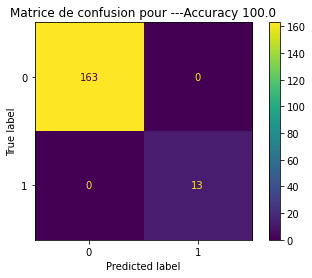

DecisionTreeClassifier()

Model: Decision Tree
Accuracy: 0.9829545454545454


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 98.3')

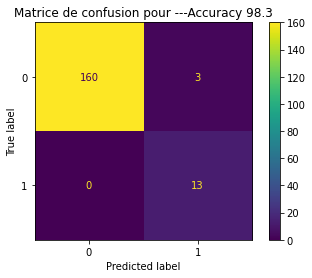

RandomForestClassifier()

Model: Random Forest
Accuracy: 0.9943181818181818


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 99.43')

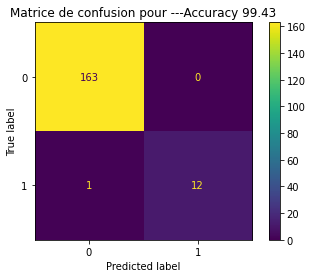

GradientBoostingClassifier()

Model: Gradient Boosting
Accuracy: 0.9943181818181818


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 99.43')

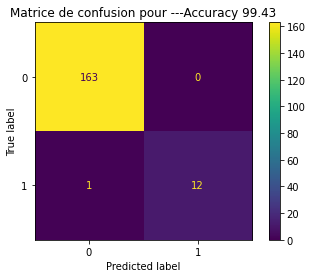

AdaBoostClassifier()

Model: AdaBoost
Accuracy: 0.9772727272727273


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 97.73')

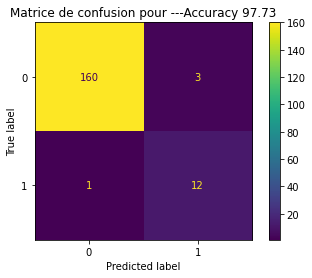

ExtraTreesClassifier()

Model: Extra Trees
Accuracy: 1.0


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 100.0')

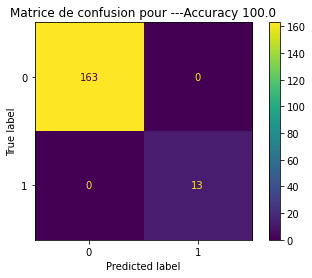

SVC(kernel='linear', probability=True)

Model: SVC
Accuracy: 1.0


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 100.0')

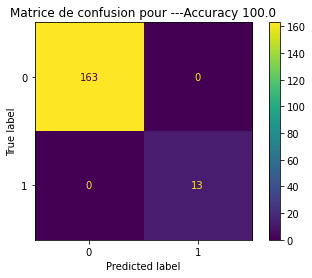

KNeighborsClassifier()

Model: K-Nearest Neighbors
Accuracy: 0.9943181818181818


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 99.43')

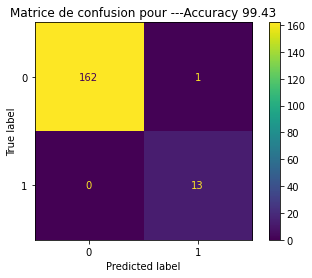

GaussianNB()

Model: Naive Bayes
Accuracy: 0.9204545454545454


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 92.05')

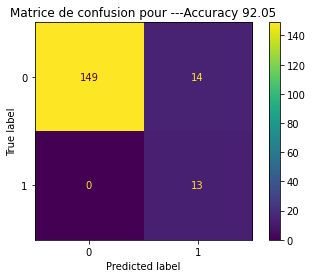

MLPClassifier(max_iter=1000)

Model: Neural Network
Accuracy: 1.0


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 100.0')

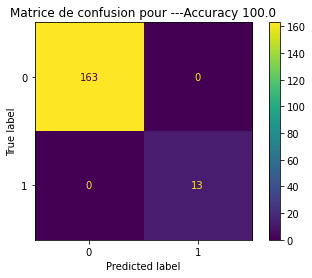

In [47]:
# Entrainement et evaluation de chaque modele
for model_name, model in models.items():

    model.fit(X_train, y_train)

    # Prédiction des probabilités sur l'ensemble de test
    y_pred_prob = model.predict_proba(X_test)

    # Calcul de la perte de log-vraisemblance (log-loss)
    loss = log_loss(y_test, y_pred_prob)

    # Prédiction des classes sur l'ensemble de test
    y_pred = model.predict(X_test)

    print(f"Model: {model_name}")
    accuracy = accuracy_score(y_test, y_pred)
    # report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    # print("Classification Report:\n", report)
    # fig, axes = plt.subplots(1, 1, figsize=(12, 5))
    
    percentage_accuracy = np.mean(y_test == y_pred) * 100
    
        
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()

    plt.title(f"Matrice de confusion pour ---Accuracy {round(percentage_accuracy, 2)}")
    plt.show()
    print("\n" + "="*80 + "\n")

#### Fuel Consumption Models

In [50]:
# Sélectionner X et y
X_fuel = final_data[['action_Aucune','action_accelerate', 'action_decelerate', 'action_stop', 'ActionParam', 'ActionDuration', 'Longitude', 'Latitude', 'Speed','Neighbors', 'LaneMaxSpeed','AllowedSpeed','weather_clear', 'weather_fog', 'weather_rain', 'weather_snow', 'weather_storm']]
y_fuel = final_data['prob_y_fuel_1']

X_fuel = X_fuel.values
y_fuel = y_fuel.values

In [52]:
# Standardisation des caractéristiques
X_fuel = scaler.fit_transform(X_fuel)

In [53]:
X_fuel_train, X_fuel_test, y_fuel_train, y_fuel_test = train_test_split(X_fuel, y_fuel, test_size=0.2, random_state=42)

LogisticRegression(max_iter=1000)

Model: Logistic Regression
Accuracy: 0.7613636363636364


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 76.14')

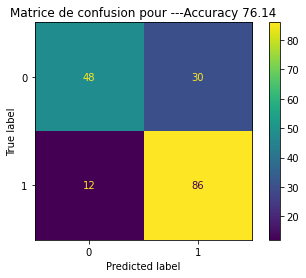

DecisionTreeClassifier()

Model: Decision Tree
Accuracy: 0.7840909090909091


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 78.41')

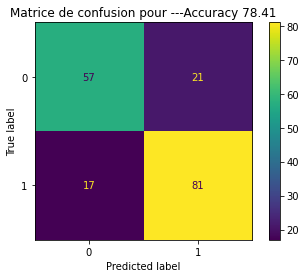

RandomForestClassifier()

Model: Random Forest
Accuracy: 0.7954545454545454


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 79.55')

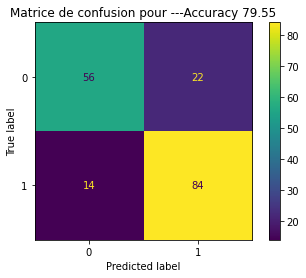

GradientBoostingClassifier()

Model: Gradient Boosting
Accuracy: 0.7556818181818182


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 75.57')

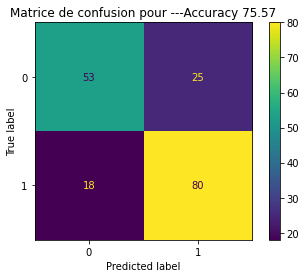

AdaBoostClassifier()

Model: AdaBoost
Accuracy: 0.7159090909090909


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 71.59')

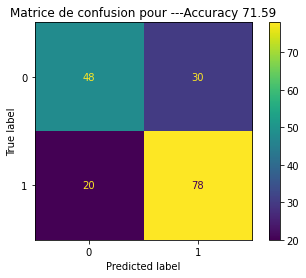

ExtraTreesClassifier()

Model: Extra Trees
Accuracy: 0.8238636363636364


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 82.39')

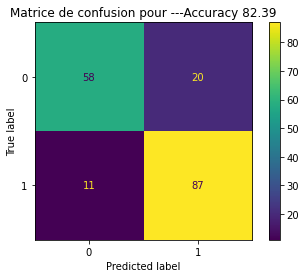

SVC(kernel='linear', probability=True)

Model: SVC
Accuracy: 0.7727272727272727


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 77.27')

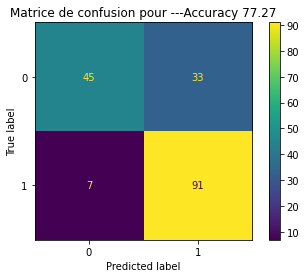

KNeighborsClassifier()

Model: K-Nearest Neighbors
Accuracy: 0.7840909090909091


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 78.41')

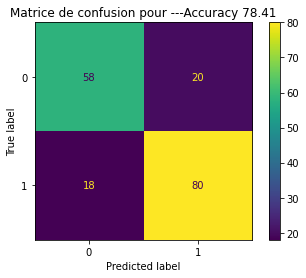

GaussianNB()

Model: Naive Bayes
Accuracy: 0.7670454545454546


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 76.7')

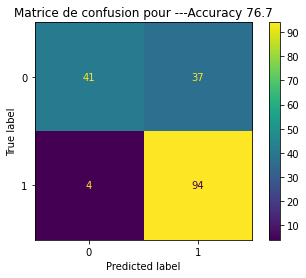

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=1000)

Model: Neural Network
Accuracy: 0.7897727272727273


Text(0.5, 1.0, 'Matrice de confusion pour ---Accuracy 78.98')

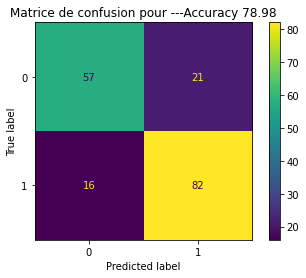

In [54]:
# Entrainement et evaluation de chaque modele
for model_name, model in models.items():

    model.fit(X_fuel_train, y_fuel_train)

    # Prédiction des probabilités sur l'ensemble de test
    y_fuel_pred_prob = model.predict_proba(X_fuel_test)

    # Calcul de la perte de log-vraisemblance (log-loss)
    loss = log_loss(y_fuel_test, y_fuel_pred_prob)

    # Prédiction des classes sur l'ensemble de test
    y_fuel_pred = model.predict(X_fuel_test)

    print(f"Model: {model_name}")
    accuracy = accuracy_score(y_fuel_test, y_fuel_pred)
    # report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    # print("Classification Report:\n", report)
    # fig, axes = plt.subplots(1, 1, figsize=(12, 5))
    
    percentage_accuracy = np.mean(y_fuel_test == y_fuel_pred) * 100
    
        
    # Matrice de confusion
    cm = confusion_matrix(y_fuel_test, y_fuel_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()

    plt.title(f"Matrice de confusion pour ---Accuracy {round(percentage_accuracy, 2)}")
    plt.show()
    print("\n" + "="*80 + "\n")

#### Relation entre les entrees et les sorties

In [48]:
encoded_data.columns

Index(['DateTime', 'VehicleID', 'X', 'Y', 'Longitude', 'Latitude', 'Speed',
       'FuelConsumption', 'CO2Emission', 'TravelTime', 'Meteo', 'ActionId',
       'ActionName', 'ActionParam', 'ActionDuration', 'LaneMaxSpeed',
       'Neighbors', 'AllowedSpeed', 'y_travel', 'y_fuel', 'weather_encoded'],
      dtype='object')

In [84]:
# Liste des colonnes quantitatives
quantitative_cols = ['X', 'Y', 'Speed', 'ActionParam', 'ActionDuration', 
                     'LaneMaxSpeed', 'Neighbors', 'AllowedSpeed']

# Liste des colonnes qualitatives
qualitative_cols = ['Meteo', 'ActionName', 'ActionId']

In [61]:
# # Visualisation des colonnes quantitatives
# for col in quantitative_cols:
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(data=data, x=col, y='y_travel', hue='y_travel', palette={-1: 'red', 1: 'blue'})
#     plt.title(f'Relation entre {col} et y_travel')
#     plt.xlabel(col)
#     plt.ylabel('y_travel')
#     plt.show()

In [63]:
# # Visualisation des colonnes qualitatives
# for col in qualitative_cols:
#     plt.figure(figsize=(10, 8))
#     sns.boxplot(data=data, x=col, y='y_travel')
#     # plt.title(f'Relation entre {col} et y_travel')
#     plt.xlabel(col)
#     plt.ylabel('y_travel')
#     plt.xticks(rotation=45)  # Si les étiquettes sont longues
#     plt.show()

<AxesSubplot:xlabel='X', ylabel='y_travel'>

Text(0.5, 1.0, 'Relation entre X et y_travel')

Text(0.5, 0, 'X')

Text(0, 0.5, 'y_travel')

<AxesSubplot:xlabel='Y', ylabel='y_travel'>

Text(0.5, 1.0, 'Relation entre Y et y_travel')

Text(0.5, 0, 'Y')

Text(0, 0.5, 'y_travel')

<AxesSubplot:xlabel='Speed', ylabel='y_travel'>

Text(0.5, 1.0, 'Relation entre Speed et y_travel')

Text(0.5, 0, 'Speed')

Text(0, 0.5, 'y_travel')

<AxesSubplot:xlabel='ActionParam', ylabel='y_travel'>

Text(0.5, 1.0, 'Relation entre ActionParam et y_travel')

Text(0.5, 0, 'ActionParam')

Text(0, 0.5, 'y_travel')

<AxesSubplot:xlabel='ActionDuration', ylabel='y_travel'>

Text(0.5, 1.0, 'Relation entre ActionDuration et y_travel')

Text(0.5, 0, 'ActionDuration')

Text(0, 0.5, 'y_travel')

<AxesSubplot:xlabel='LaneMaxSpeed', ylabel='y_travel'>

Text(0.5, 1.0, 'Relation entre LaneMaxSpeed et y_travel')

Text(0.5, 0, 'LaneMaxSpeed')

Text(0, 0.5, 'y_travel')

<AxesSubplot:xlabel='Neighbors', ylabel='y_travel'>

Text(0.5, 1.0, 'Relation entre Neighbors et y_travel')

Text(0.5, 0, 'Neighbors')

Text(0, 0.5, 'y_travel')

<AxesSubplot:xlabel='AllowedSpeed', ylabel='y_travel'>

Text(0.5, 1.0, 'Relation entre AllowedSpeed et y_travel')

Text(0.5, 0, 'AllowedSpeed')

Text(0, 0.5, 'y_travel')

<AxesSubplot:xlabel='Meteo', ylabel='y_travel'>

Text(0.5, 1.0, 'Relation entre Meteo et y_travel')

Text(0.5, 0, 'Meteo')

Text(0, 0.5, 'y_travel')

<AxesSubplot:xlabel='ActionName', ylabel='y_travel'>

Text(0.5, 1.0, 'Relation entre ActionName et y_travel')

Text(0.5, 0, 'ActionName')

Text(0, 0.5, 'y_travel')

<AxesSubplot:xlabel='ActionId', ylabel='y_travel'>

Text(0.5, 1.0, 'Relation entre ActionId et y_travel')

Text(0.5, 0, 'ActionId')

Text(0, 0.5, 'y_travel')

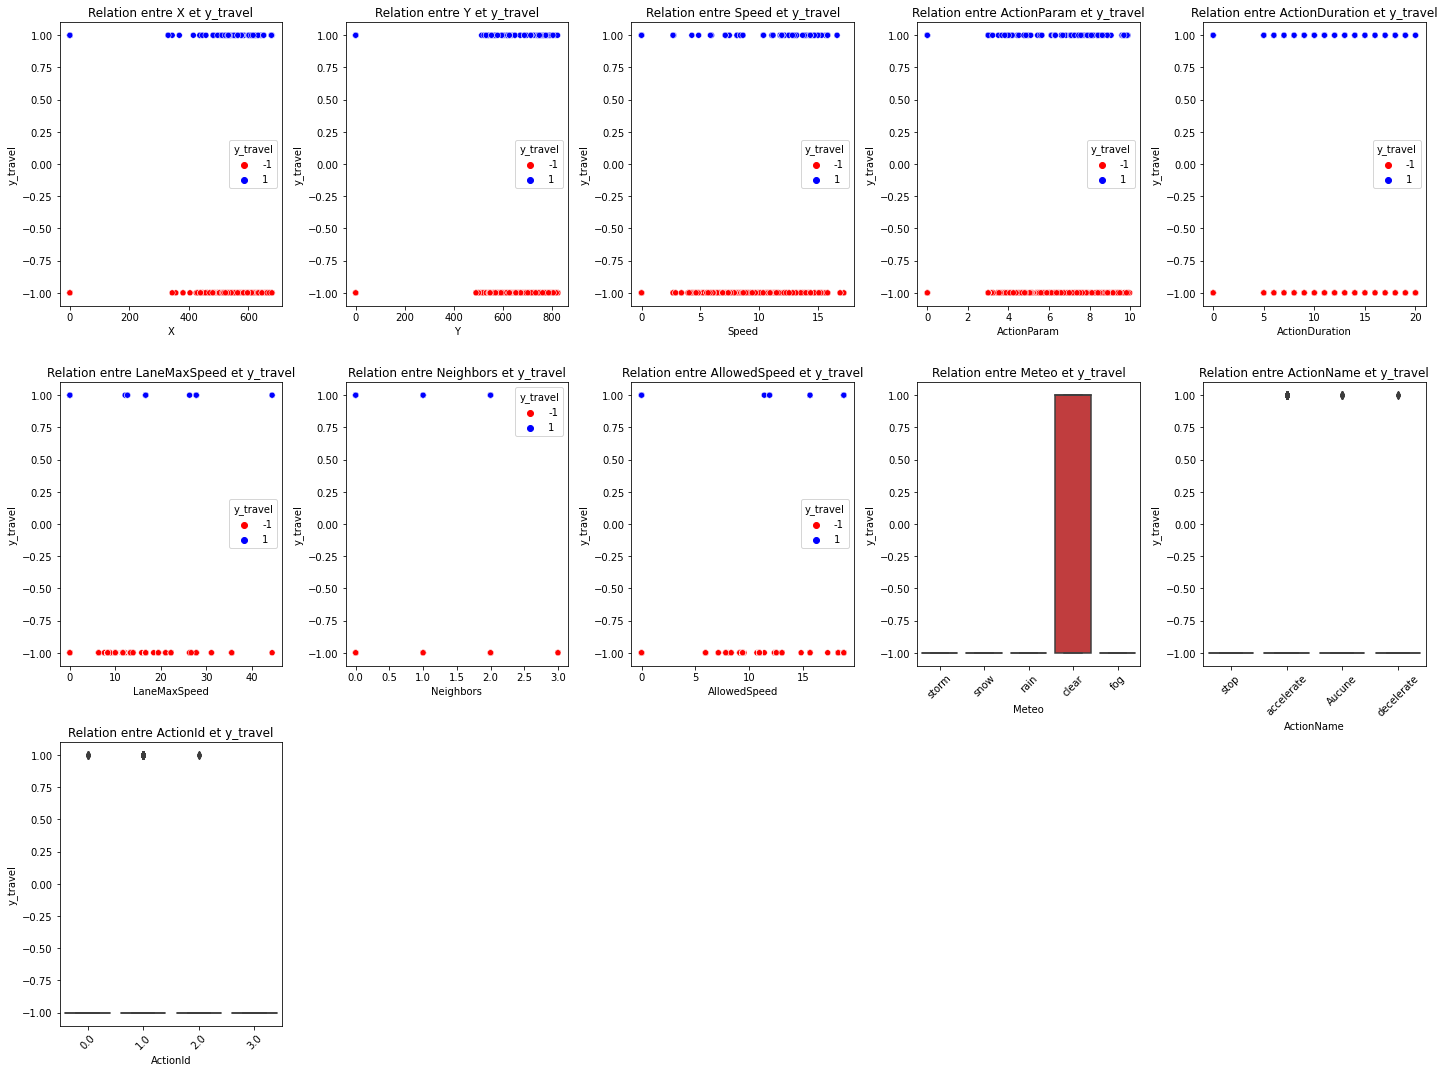

In [85]:
import math

# Nombre total de colonnes
total_cols = len(quantitative_cols) + len(qualitative_cols)
cols_per_row = 5
rows = math.ceil(total_cols / cols_per_row)

# Créer une figure et des axes
fig, axes = plt.subplots(rows, cols_per_row, figsize=(20, rows * 5))

# Aplatir les axes pour un accès facile
axes = axes.flatten()

# Visualisation des colonnes quantitatives
for i, col in enumerate(quantitative_cols):
    sns.scatterplot(data=data, x=col, y='y_travel', hue='y_travel', palette={-1: 'red', 1: 'blue'}, ax=axes[i])
    axes[i].set_title(f'Relation entre {col} et y_travel')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('y_travel')

# Visualisation des colonnes qualitatives
for i, col in enumerate(qualitative_cols, start=len(quantitative_cols)):
    sns.boxplot(data=data, x=col, y='y_travel', ax=axes[i])
    axes[i].set_title(f'Relation entre {col} et y_travel')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('y_travel')
    axes[i].tick_params(axis='x', rotation=45)  # Rotation des étiquettes si elles sont longues

# Supprimer les axes vides
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()


In [69]:
# import math

# # Nombre total de colonnes
# total_cols = len(quantitative_cols) + len(qualitative_cols)
# cols_per_row = 5
# rows = math.ceil(total_cols / cols_per_row)

# # Créer une figure et des axes
# fig, axes = plt.subplots(rows, cols_per_row, figsize=(20, rows * 5))

# # Aplatir les axes pour un accès facile
# axes = axes.flatten()

# # Visualisation des colonnes quantitatives
# for i, col in enumerate(quantitative_cols):
#     sns.scatterplot(data=data, x=col, y='y_travel', hue='y_fuel', palette={-1: 'red', 1: 'blue'}, ax=axes[i])
#     axes[i].set_title(f'Relation entre {col} et y_fuel')
#     axes[i].set_xlabel(col)
#     axes[i].set_ylabel('y_travel')

# # Visualisation des colonnes qualitatives
# for i, col in enumerate(qualitative_cols, start=len(quantitative_cols)):
#     sns.boxplot(data=data, x=col, y='y_fuel', ax=axes[i])
#     axes[i].set_title(f'Relation entre {col} et y_fuel')
#     axes[i].set_xlabel(col)
#     axes[i].set_ylabel('y_travel')
#     axes[i].tick_params(axis='x', rotation=45)  # Rotation des étiquettes si elles sont longues

# # Supprimer les axes vides
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# # Ajuster l'espacement entre les sous-graphiques
# plt.tight_layout()
# plt.show()


In [77]:
len(data[(data.ActionId == 1) & (data.y_travel == 1)])

80

In [83]:
len(data[(data.weather_encoded == 3) & (data.y_travel == 1)])

0

y_travel     -1   1
ActionName         
Aucune       24   7
accelerate  260  80
decelerate  303   3
stop        232   0


<AxesSubplot:xlabel='ActionName'>

Text(0.5, 1.0, "Nombre de fois où y_travel prend 1 et -1 pour chaque type d'action")

Text(0.5, 0, "Type d'action")

Text(0, 0.5, "Nombre d'occurrences")

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Aucune'),
  Text(1, 0, 'accelerate'),
  Text(2, 0, 'decelerate'),
  Text(3, 0, 'stop')])

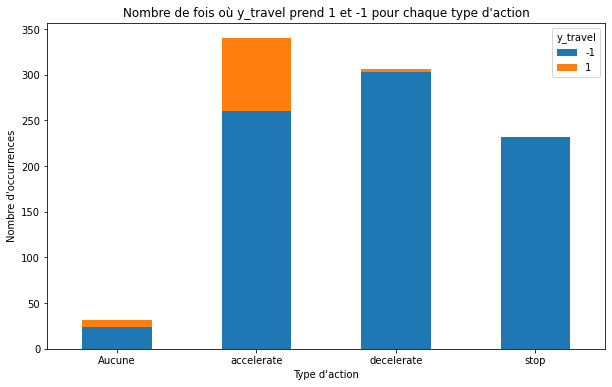

In [86]:
# Compter les occurrences de chaque type d'action pour chaque valeur de y_travel
action_counts = data.groupby(['ActionName', 'y_travel']).size().unstack(fill_value=0)

# Afficher les résultats
print(action_counts)

# Création du graphique à barres empilées
action_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

# Ajouter des labels et un titre
plt.title('Nombre de fois où y_travel prend 1 et -1 pour chaque type d\'action')
plt.xlabel('Type d\'action')
plt.ylabel('Nombre d\'occurrences')
plt.legend(title='y_travel')
plt.xticks(rotation=0)

# Afficher le graphique
plt.show()

y_travel   -1   1
Meteo            
clear      79  90
fog       186   0
rain      189   0
snow      175   0
storm     190   0


<AxesSubplot:xlabel='Meteo'>

Text(0.5, 1.0, 'Nombre de fois où y_travel prend 1 et -1 pour chaque meteo')

Text(0.5, 0, 'Meteo')

Text(0, 0.5, "Nombre d'occurrences")

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'clear'),
  Text(1, 0, 'fog'),
  Text(2, 0, 'rain'),
  Text(3, 0, 'snow'),
  Text(4, 0, 'storm')])

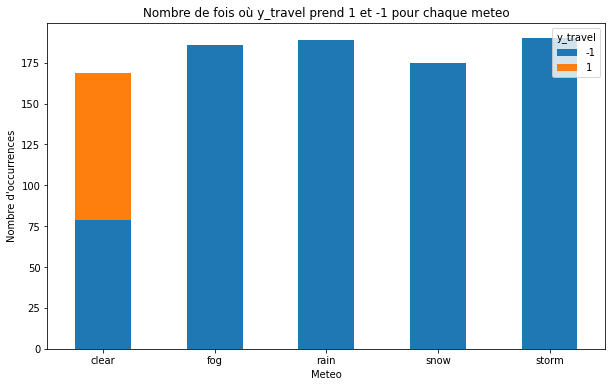

In [87]:
# Compter les occurrences de chaque type d'action pour chaque valeur de y_travel
meteo_counts = data.groupby(['Meteo', 'y_travel']).size().unstack(fill_value=0)

# Afficher les résultats
print(meteo_counts)

# Création du graphique à barres empilées
meteo_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

# Ajouter des labels et un titre
plt.title('Nombre de fois où y_travel prend 1 et -1 pour chaque meteo')
plt.xlabel('Meteo')
plt.ylabel('Nombre d\'occurrences')
plt.legend(title='y_travel')
plt.xticks(rotation=0)

# Afficher le graphique
plt.show()